<h1 align="center">Analysing User Experience on E-Commerce Apps using Sentiment Analysis</h1>

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## 2. Load Datasets

In [2]:
alibaba_df = pd.read_csv('/kaggle/input/user-experience-on-e-commerce-apps/Datasets/Alibaba-app-review.csv')
amazon_df = pd.read_csv('/kaggle/input/user-experience-on-e-commerce-apps/Datasets/Amazon-app-review.csv')
flipkart_df = pd.read_csv('/kaggle/input/user-experience-on-e-commerce-apps/Datasets/Flipkart-app-review.csv')
nyakaa_df = pd.read_csv('/kaggle/input/user-experience-on-e-commerce-apps/Datasets/Nyakaa-app-review.csv')
shopify_df = pd.read_csv('/kaggle/input/user-experience-on-e-commerce-apps/Datasets/Shopify-reviews.csv')

## 3. Data Preview

In [3]:
all_df = {
    "Alibaba": alibaba_df, "Amazon": amazon_df, 
    "Flipkart": flipkart_df, "Nyakaa": nyakaa_df,
    "Shopify": shopify_df
}

In [4]:
for df in all_df.values():
    display(df.head())

review  rating  \
0  I ve bought mostly everything for my business ...       5   
1  I like Alibaba a lot, however it needs to be b...       3   
2  I ordered items and seen that it shipped. That...       1   
3  Overall pretty good app. Shipping from anywher...       1   
4  Alibaba needs more shipping options to the U.S...       3   

                                   preprocessed_text  \
0  i ve bought mostly everything for my business ...   
1  i like alibaba a lot however it needs to be br...   
2  i ordered items and seen that it shipped that ...   
3  overall pretty good app shipping from anywhere...   
4  alibaba needs more shipping options to the us ...   

                                      tokenized_text  
0  ['bought', 'mostli', 'everyth', 'busi', 'aliba...  
1  ['like', 'alibaba', 'lot', 'howev', 'need', 'b...  
2  ['order', 'item', 'seen', 'ship', 'great', 'ti...  
3  ['overal', 'pretti', 'good', 'app', 'ship', 'a...  
4  ['alibaba', 'need', 'ship', 'option', 'us', 'r...

reviewId             userName  \
0  1e1579be-7f4b-4cf4-88fd-4a378f26543f  Alander Tsiolkovsky   
1  e84614cf-7009-45eb-9270-0c3eb745e1d0        Lamont Walker   
2  d1a121ea-0e13-4e85-9132-d459e47f5b37        Melani Vargas   
3  5999e8a3-eaad-4328-9613-2489975aae4e                  OCF   
4  0478ac98-b4b1-4934-a6f3-edd0ecf2cf00          Brian Diego   

                                             content  score  thumbsUpCount  \
0  🔺️😡 Honestly, the Packaging mostly is bad and ...      1              0   
1        Interface is as trash as the service itself      1              0   
2  I’m going to be truly honest about my experien...      5              0   
3  Just can't be doing with the biased algorithms...      2              0   
4  Experience had gotten better but lately, they ...      2             51   

  reviewCreatedVersion                   at   appVersion  
0          28.17.0.100  2024-09-22 02:57:05  28.17.0.100  
1          28.18.0.100  2024-09-22 01:12:05  28.18.0.100  
2          28.18.0.100  2024-09-21 08:41:19  28.18.0.100  
3          28.18.0.100  2024-09-21 08:20:20  28.18.0.100  
4          28.18.0.100  2024-09-21 02:37:55  28.18.0.100

Unnamed: 0                                        review_text  \
0           7  It's amazing to have u on the cell but plz imp...   
1          56             Nice.. But w8n 4 an upgraded interface   
2         104           not worth installing... bad interface...   
3         111  this app is less of an app and more of an inte...   
4         159  Im really disappoint from flipkart User-Interf...   

   review_rating author_id    author_name author_app_version  \
0            4.0       NaN  A Google user              1.0.0   
1            5.0       NaN  A Google user                NaN   
2            1.0       NaN  A Google user                NaN   
3            2.0       NaN  A Google user              1.0.1   
4            1.0       NaN  A Google user                NaN   

        review_datetime_utc  review_likes  
0  2011-11-26T11:14:00.000Z             1  
1  2012-07-18T14:05:50.000Z             0  
2  2012-09-30T11:11:06.000Z             0  
3  2012-10-07T00:50:48.000Z             0  
4  2012-10-31T16:38:00.000Z             0

content sentiment_labels
0    absolute love😍😍experience best offers always...         POSITIVE
1  Such a pathetic app. It takes month long deliv...         NEGATIVE
2                             Awesome experience,😄😄😄         POSITIVE
3       Fantastic hassle free app a great experience         POSITIVE
4  It was a great experience ordering items 😊 and...          NEUTRAL

app_id               author  rating  \
0  cd229797-5798-4465-a313-2e27ce44e01d  Sweet E's Bake Shop       5   
1  cd229797-5798-4465-a313-2e27ce44e01d      Budget Workwear       5   
2  c3488a55-5831-4a97-bf5b-dbb9231f8d0b             Patarata       5   
3  0bf899ad-728f-4695-8dd5-cd510a27a4b2             Intimisa       5   
4  20bdf894-d306-4875-b094-c4e0d5595f16     Lykaia Nutrition       5   

                 posted_at                                               body  \
0  Edited February 4, 2020  HOLY CRAP! This app is AMAZING. Installation w...   
1             May 16, 2019  This is an amazing app! It works perfect with ...   
2             May 24, 2022  I've used this app to source all products from...   
3            March 2, 2022  Seems like it works pretty good for me so far....   
4             May 25, 2022  The interface is a little tricky but the Custo...   

   helpful_count                                    developer_reply  \
0              1                                                NaN   
1              3                                                NaN   
2              0  Thanks for your wonderful feedback! This has b...   
3              0                                                NaN   
4              0                                                NaN   

  developer_reply_posted_at  
0                       NaN  
1                       NaN  
2              May 24, 2022  
3                       NaN  
4                       NaN

## 4. Data Wrangling

I will need to create work with functions in order to analyse the dataframes simultaneously. Hence the dataframes need to have the same column name and structure

In [5]:
alibaba_df = alibaba_df[['review']]
amazon_df = amazon_df[['content']].rename(columns={'content': 'review'}) 
flipkart_df = flipkart_df[['review_text']].rename(columns={'review_text': 'review'})
nyakaa_df = nyakaa_df[['content']].rename(columns={'content': 'review'})
shopify_df = shopify_df[['body']].rename(columns={'body': 'review'})

In [6]:
all_df = {
    "Alibaba": alibaba_df, "Amazon": amazon_df, 
    "Flipkart": flipkart_df, "Nyakaa": nyakaa_df,
    "Shopify": shopify_df
}

for df in all_df.values():
    display(df.head())

review
0  I ve bought mostly everything for my business ...
1  I like Alibaba a lot, however it needs to be b...
2  I ordered items and seen that it shipped. That...
3  Overall pretty good app. Shipping from anywher...
4  Alibaba needs more shipping options to the U.S...

review
0  🔺️😡 Honestly, the Packaging mostly is bad and ...
1        Interface is as trash as the service itself
2  I’m going to be truly honest about my experien...
3  Just can't be doing with the biased algorithms...
4  Experience had gotten better but lately, they ...

review
0  It's amazing to have u on the cell but plz imp...
1             Nice.. But w8n 4 an upgraded interface
2           not worth installing... bad interface...
3  this app is less of an app and more of an inte...
4  Im really disappoint from flipkart User-Interf...

review
0    absolute love😍😍experience best offers always...
1  Such a pathetic app. It takes month long deliv...
2                             Awesome experience,😄😄😄
3       Fantastic hassle free app a great experience
4  It was a great experience ordering items 😊 and...

review
0  HOLY CRAP! This app is AMAZING. Installation w...
1  This is an amazing app! It works perfect with ...
2  I've used this app to source all products from...
3  Seems like it works pretty good for me so far....
4  The interface is a little tricky but the Custo...

## 5. Exploratory Data Analysis

In [7]:
def plot_wordcloud(text, app_name):
    wordcloud = WordCloud(width=900, height=500, background_color='white', random_state=42).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Wordcloud showing the most frequent words of {app_name} reviewers', pad=15)
    plt.axis('off')
    plt.show()

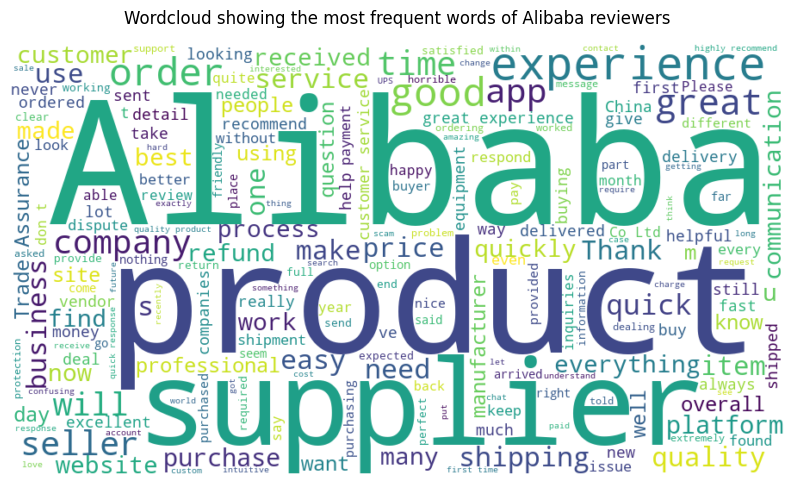

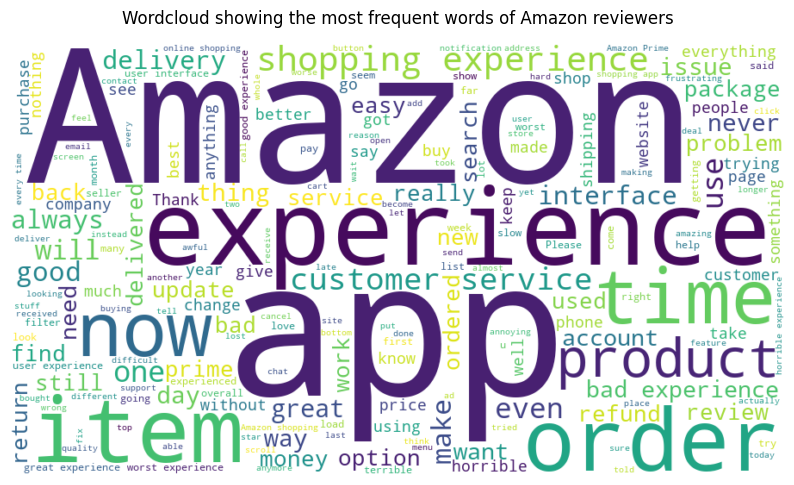

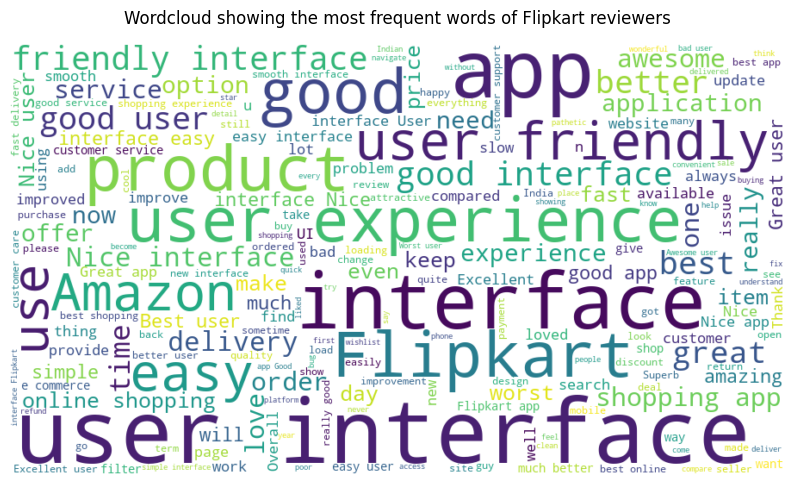

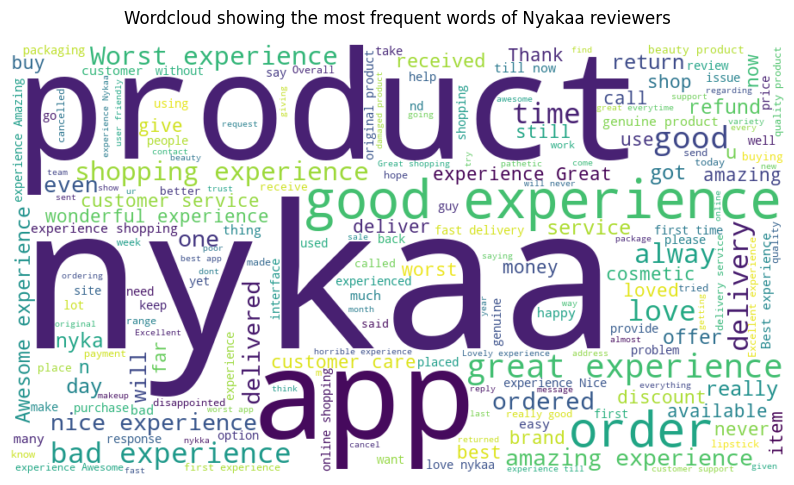

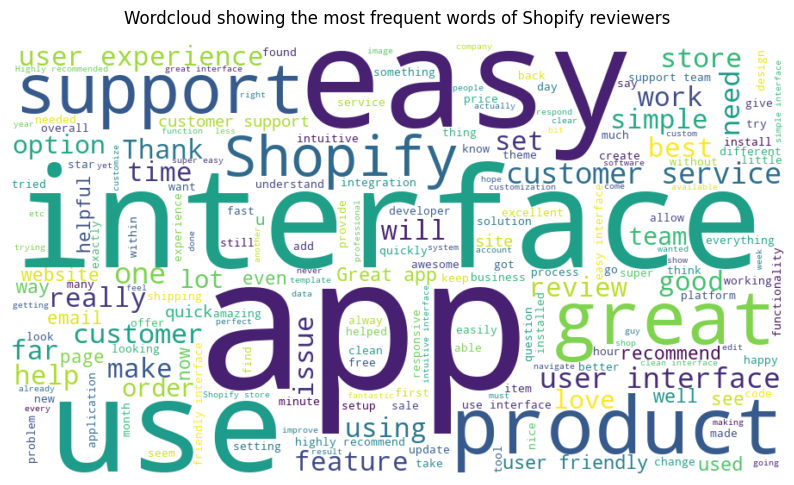

In [8]:
for app_name, df in all_df.items():
    review_text = ' '.join(df['review'])
    plot_wordcloud(review_text, app_name=app_name)

## 6. Data Preprocessing

In [9]:
# Kaggle required command
# !unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/ > null

Perform standard processing:

- Convert to lowercase
- Tokenization
- Remove punctuations
- Remove stopwords
- Perform lemmatization

In [10]:
# Get stopwords
stop_words = stopwords.words('english')

# Initialize lemmatizer 
lemmatizer = WordNetLemmatizer()

In [11]:
def preprocess_review(review):
    
    # Tokenization
    tokens = word_tokenize(review)
    
    # Process tokens: remove punctuation, convert to lowercase, remove stopwords, and lemmatize
    processed_tokens = [
        lemmatizer.lemmatize(word.lower())
        for word in tokens if word.isalpha() and word.lower() not in stop_words
    ]
    
    return ' '.join(processed_tokens)

In [12]:
for df in all_df.values():
    df['preprocessed_review'] = df['review'].apply(preprocess_review)

In [13]:
all_df = {
    "Alibaba": alibaba_df, "Amazon": amazon_df, 
    "Flipkart": flipkart_df, "Nyakaa": nyakaa_df,
    "Shopify": shopify_df
}

for df in all_df.values():
    display(df.head())

review  \
0  I ve bought mostly everything for my business ...   
1  I like Alibaba a lot, however it needs to be b...   
2  I ordered items and seen that it shipped. That...   
3  Overall pretty good app. Shipping from anywher...   
4  Alibaba needs more shipping options to the U.S...   

                                 preprocessed_review  
0  bought mostly everything business alibaba supp...  
1  like alibaba lot however need brought app malf...  
2  ordered item seen shipped great time three wee...  
3  overall pretty good app shipping anywhere take...  
4  alibaba need shipping option researched purcha...

review  \
0  🔺️😡 Honestly, the Packaging mostly is bad and ...   
1        Interface is as trash as the service itself   
2  I’m going to be truly honest about my experien...   
3  Just can't be doing with the biased algorithms...   
4  Experience had gotten better but lately, they ...   

                                 preprocessed_review  
0  honestly packaging mostly bad thing order come...  
1                            interface trash service  
2  going truly honest experience first time order...  
3  ca biased algorithm product suggestion hate in...  
4  experience gotten better lately dropped ball l...

review  \
0  It's amazing to have u on the cell but plz imp...   
1             Nice.. But w8n 4 an upgraded interface   
2           not worth installing... bad interface...   
3  this app is less of an app and more of an inte...   
4  Im really disappoint from flipkart User-Interf...   

                                 preprocessed_review  
0  amazing u cell plz improve ui also let interfa...  
1                                 upgraded interface  
2                     worth installing bad interface  
3  app le app interface mobile site flippy howevr...  
4  im really disappoint flipkart nothing simple i...

review  \
0    absolute love😍😍experience best offers always...   
1  Such a pathetic app. It takes month long deliv...   
2                             Awesome experience,😄😄😄   
3       Fantastic hassle free app a great experience   
4  It was a great experience ordering items 😊 and...   

                                 preprocessed_review  
0                         absolute best offer always  
1  pathetic app take month long delivery cherry c...  
2                                 awesome experience  
3         fantastic hassle free app great experience  
4  great experience ordering item must download a...

review  \
0  HOLY CRAP! This app is AMAZING. Installation w...   
1  This is an amazing app! It works perfect with ...   
2  I've used this app to source all products from...   
3  Seems like it works pretty good for me so far....   
4  The interface is a little tricky but the Custo...   

                                 preprocessed_review  
0  holy crap app amazing installation breeze inte...  
1  amazing app work perfect shopify store quantif...  
2  used app source product store found process re...  
3  seems like work pretty good far convenient int...  
4  interface little tricky customer support pheno...

## 6. Sentiment Analysis using Vader

There are four sentiment type values returned when we use vader sentiment analyzer:

- neg for negative sentiment
- neu for neutral sentiment
- pos for positive sentiment
- compound for an overall score that combines negative, positive, and neutral sentiments into a single score.

In our case, the compound score is the most useful metric since we want a single unidimensional measure of sentiment for a given sentence. The threshold value I used is

- positive sentiment: compound score > 0
- negative sentiment: compound score < 0
- neutral sentiment: compound score = 0

In [14]:
analyzer = SentimentIntensityAnalyzer()

In [15]:
def analyze_sentiment(lyrics):
    scores = analyzer.polarity_scores(lyrics)
    compound_score = scores['compound']
    if compound_score > 0:
        sentiment = 'positive'
    elif compound_score < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    return compound_score, sentiment

In [16]:
for df in all_df.values():
    df[['vader_compound_score', 'vader_sentiment']] = df['preprocessed_review'].apply(lambda x: pd.Series(analyze_sentiment(x)))

In [17]:
all_df = {
    "Alibaba": alibaba_df, "Amazon": amazon_df, 
    "Flipkart": flipkart_df, "Nyakaa": nyakaa_df,
    "Shopify": shopify_df
}

for df in all_df.values():
    display(df.head())

review  \
0  I ve bought mostly everything for my business ...   
1  I like Alibaba a lot, however it needs to be b...   
2  I ordered items and seen that it shipped. That...   
3  Overall pretty good app. Shipping from anywher...   
4  Alibaba needs more shipping options to the U.S...   

                                 preprocessed_review  vader_compound_score  \
0  bought mostly everything business alibaba supp...                0.8225   
1  like alibaba lot however need brought app malf...                0.9813   
2  ordered item seen shipped great time three wee...                0.8834   
3  overall pretty good app shipping anywhere take...               -0.9650   
4  alibaba need shipping option researched purcha...                0.9709   

  vader_sentiment  
0        positive  
1        positive  
2        positive  
3        negative  
4        positive

review  \
0  🔺️😡 Honestly, the Packaging mostly is bad and ...   
1        Interface is as trash as the service itself   
2  I’m going to be truly honest about my experien...   
3  Just can't be doing with the biased algorithms...   
4  Experience had gotten better but lately, they ...   

                                 preprocessed_review  vader_compound_score  \
0  honestly packaging mostly bad thing order come...               -0.9595   
1                            interface trash service                0.0000   
2  going truly honest experience first time order...                0.6486   
3  ca biased algorithm product suggestion hate in...               -0.8481   
4  experience gotten better lately dropped ball l...               -0.3818   

  vader_sentiment  
0        negative  
1         neutral  
2        positive  
3        negative  
4        negative

review  \
0  It's amazing to have u on the cell but plz imp...   
1             Nice.. But w8n 4 an upgraded interface   
2           not worth installing... bad interface...   
3  this app is less of an app and more of an inte...   
4  Im really disappoint from flipkart User-Interf...   

                                 preprocessed_review  vader_compound_score  \
0  amazing u cell plz improve ui also let interfa...                0.7906   
1                                 upgraded interface                0.0000   
2                     worth installing bad interface               -0.3818   
3  app le app interface mobile site flippy howevr...                0.7906   
4  im really disappoint flipkart nothing simple i...               -0.4576   

  vader_sentiment  
0        positive  
1         neutral  
2        negative  
3        positive  
4        negative

review  \
0    absolute love😍😍experience best offers always...   
1  Such a pathetic app. It takes month long deliv...   
2                             Awesome experience,😄😄😄   
3       Fantastic hassle free app a great experience   
4  It was a great experience ordering items 😊 and...   

                                 preprocessed_review  vader_compound_score  \
0                         absolute best offer always                0.6369   
1  pathetic app take month long delivery cherry c...               -0.9657   
2                                 awesome experience                0.6249   
3         fantastic hassle free app great experience                0.9001   
4  great experience ordering item must download a...                0.7906   

  vader_sentiment  
0        positive  
1        negative  
2        positive  
3        positive  
4        positive

review  \
0  HOLY CRAP! This app is AMAZING. Installation w...   
1  This is an amazing app! It works perfect with ...   
2  I've used this app to source all products from...   
3  Seems like it works pretty good for me so far....   
4  The interface is a little tricky but the Custo...   

                                 preprocessed_review  vader_compound_score  \
0  holy crap app amazing installation breeze inte...                0.6778   
1  amazing app work perfect shopify store quantif...                0.9584   
2  used app source product store found process re...                0.9757   
3  seems like work pretty good far convenient int...                0.8225   
4  interface little tricky customer support pheno...                0.5314   

  vader_sentiment  
0        positive  
1        positive  
2        positive  
3        positive  
4        positive

## 7. Visualizaing Sentiment Distribution

In [18]:
plot_color = ['#FF6F61', '#008080', 'Orange']

In [19]:
def plot_sentiment_distribution(df, sentiment_column, app_name):
    sentiment_counts = df[sentiment_column].value_counts()
    sentiment_labels = sentiment_counts.index
    sentiment_sizes = sentiment_counts.values

    # Custom colors for the pie chart
    plot_colors = ['#FF6F61', '#008080', '#FFA500'] 

    plt.figure(figsize=(8, 8))
    patches, texts, autotexts = plt.pie(sentiment_sizes, autopct='%1.1f%%', startangle=140, colors=plot_colors)
    
    plt.legend(patches, sentiment_labels, loc="best")
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f'Sentiment Distribution for {app_name}')
    plt.show()

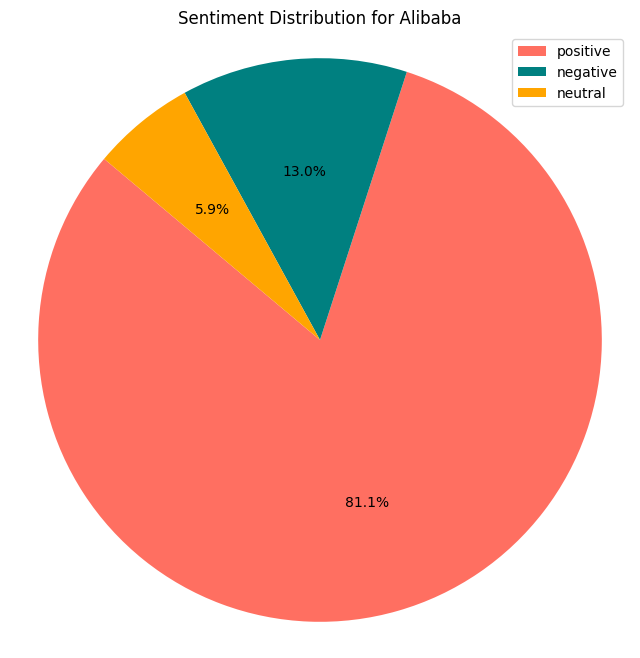

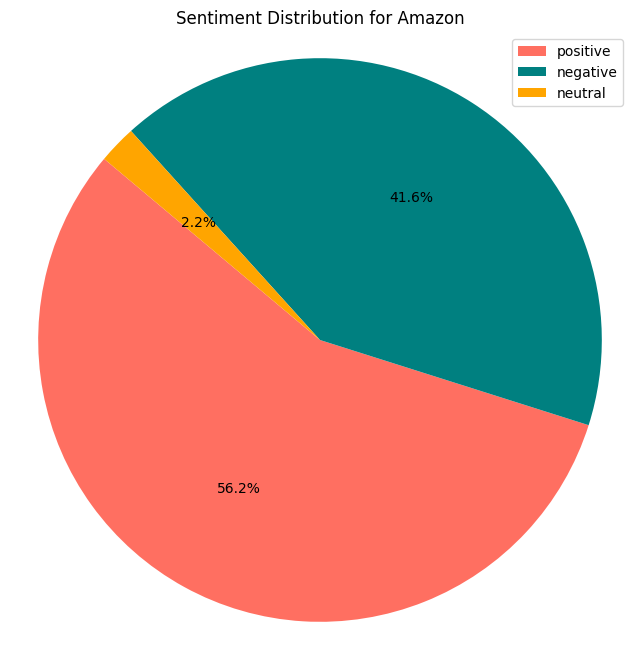

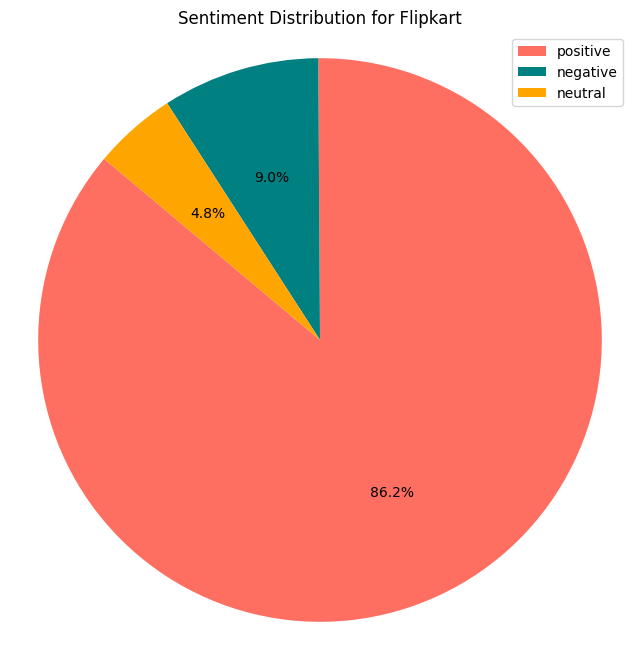

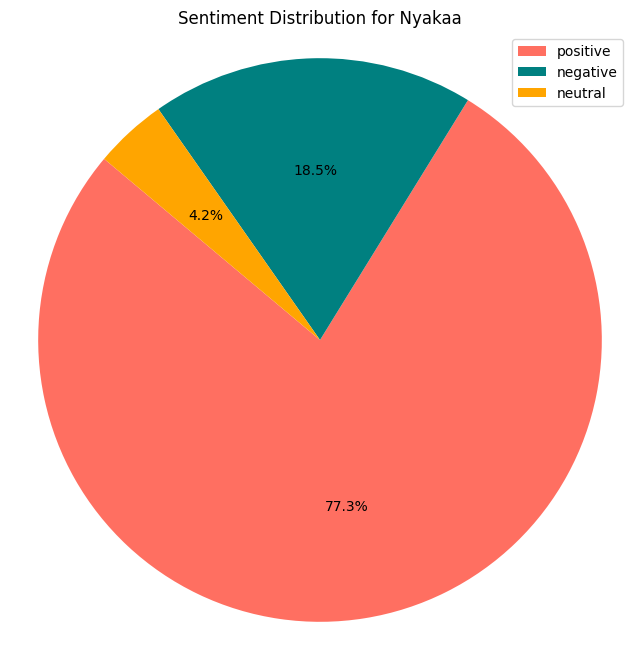

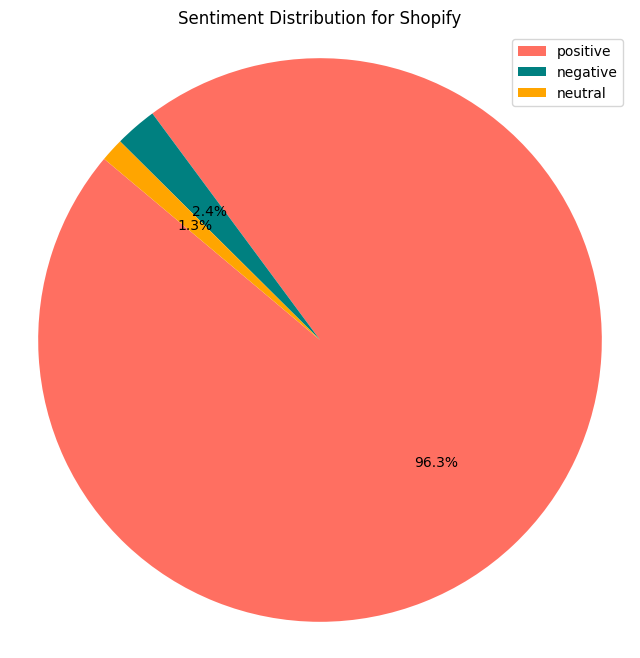

In [20]:
# Plot VADER sentiment distribution

for app_name, df in all_df.items():
    plot_sentiment_distribution(df, 'vader_sentiment', app_name)

In [21]:
for app_name, df in all_df.items():
    print(f'Shape of {app_name.lower()} dataframe is: {df.shape}')

Shape of alibaba dataframe is: (355, 4)
Shape of amazon dataframe is: (2972, 4)
Shape of flipkart dataframe is: (9906, 4)
Shape of nyakaa dataframe is: (7987, 4)
Shape of shopify dataframe is: (8909, 4)


The number of reviews are not the same so we can't outrightly say an app has the highest number of negative reviews. However, we can infer that Amazon has quite a high number of negative sentiments relative to the total number of reviews on the Amazon app on play store.

## 7. Visualizaing Positive Sentiment Distribution

In [22]:
def plot_wordcloud(text, app_name, sentiment_type=None):
    wordcloud = WordCloud(width=900, height=500, background_color='white', random_state=42).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Wordcloud showing {sentiment_type} Reviews of Users on {app_name} App', pad=15)
    plt.axis('off')
    plt.show()

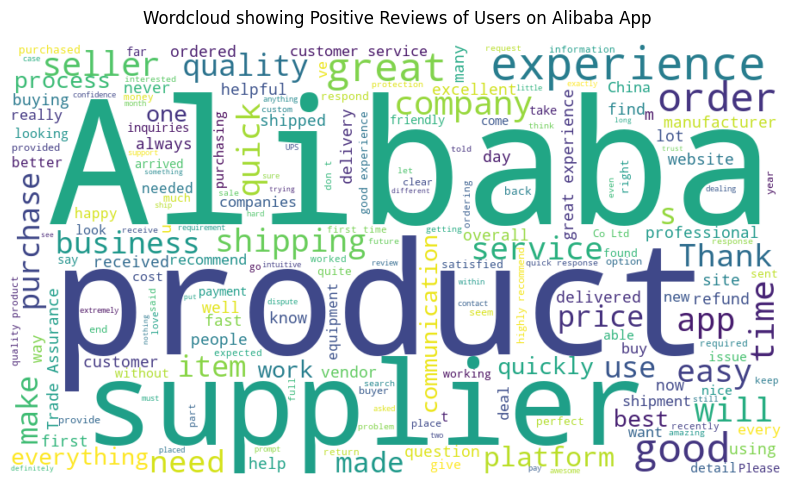

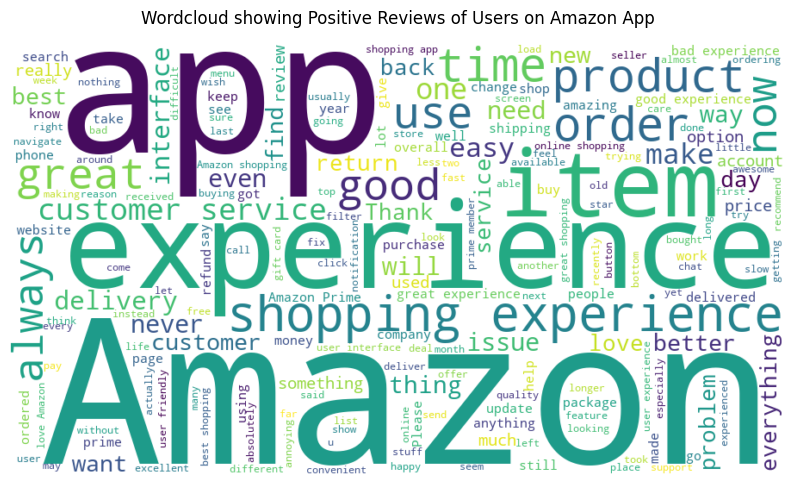

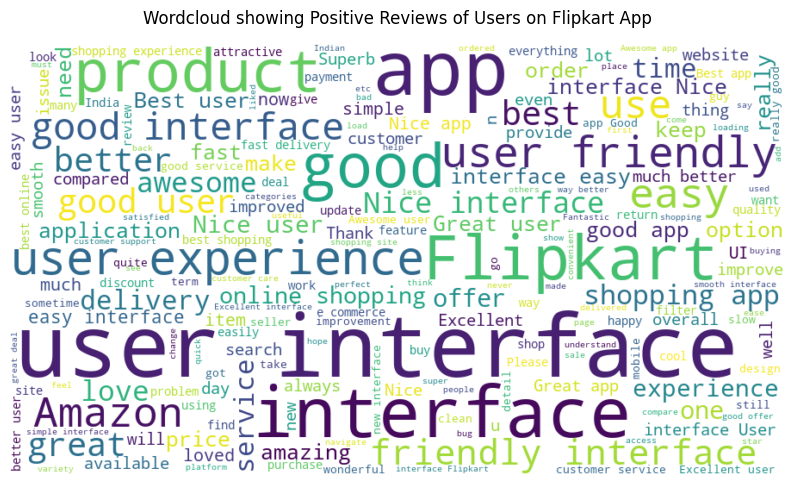

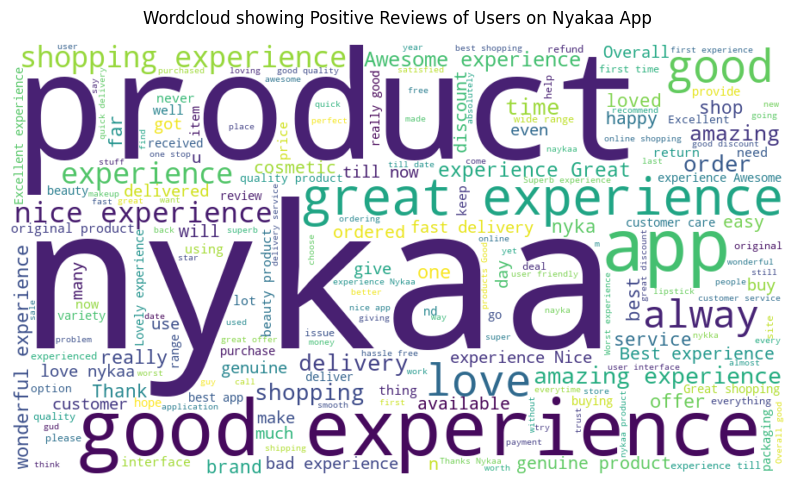

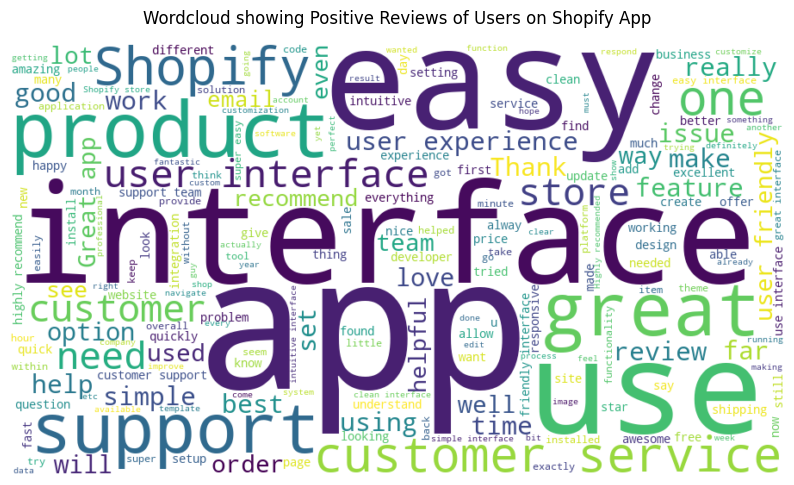

In [23]:
for app_name, df in all_df.items():
    df = df[df['vader_sentiment'] == 'positive']
    review_text = ' '.join(df['review'])
    plot_wordcloud(review_text, app_name=app_name, sentiment_type='Positive')

## 8. Visualizaing Negative Sentiment Distribution

In [24]:
def plot_wordcloud(text, app_name, sentiment_type=None):
    wordcloud = WordCloud(width=900, height=500, background_color='white', random_state=42).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Wordcloud showing {sentiment_type} Reviews of Users on {app_name} App', pad=15)
    plt.axis('off')
    plt.show()

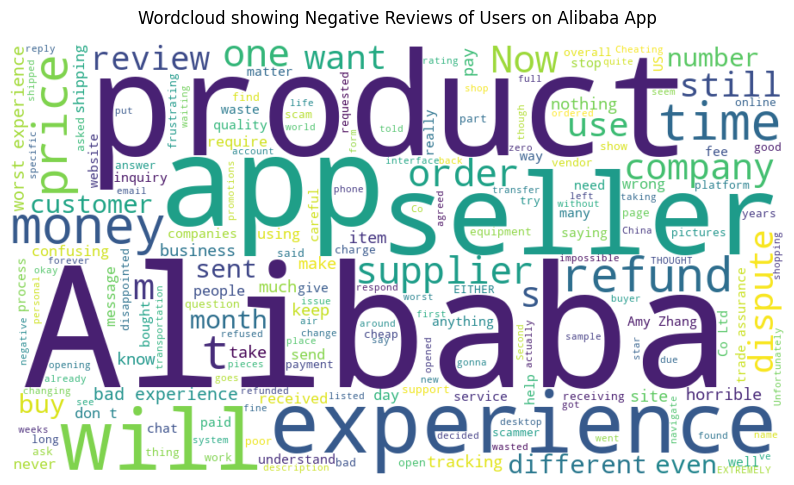

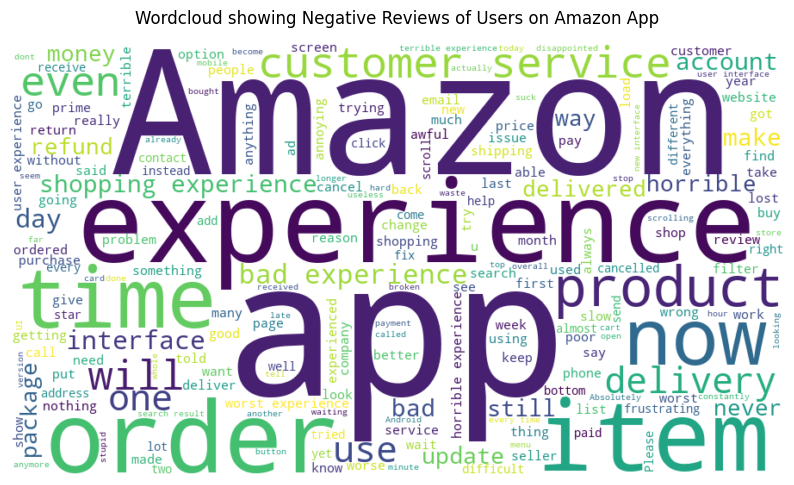

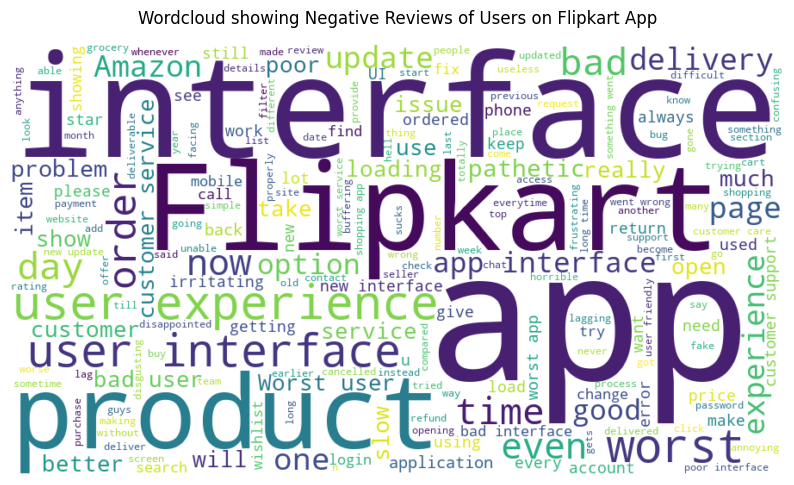

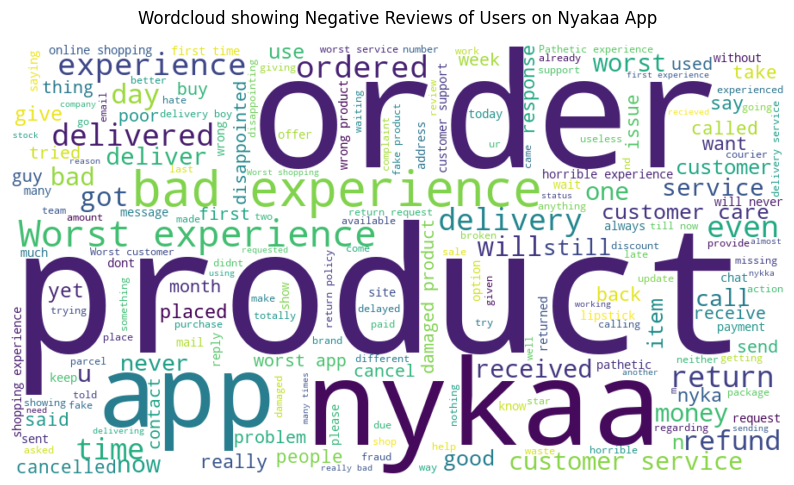

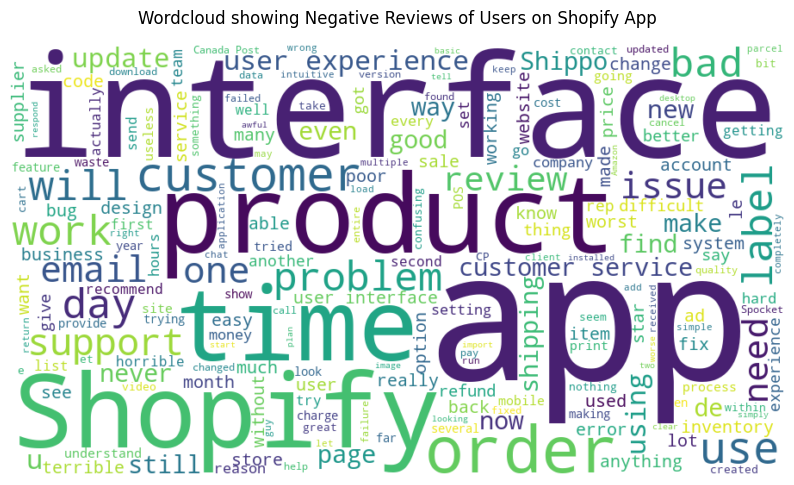

In [25]:
for app_name, df in all_df.items():
    df = df[df['vader_sentiment'] == 'negative']
    review_text = ' '.join(df['review'])
    plot_wordcloud(review_text, app_name=app_name, sentiment_type='Negative')

Feel free to conduct further analysis and draw conclusions based on the data. 

See you in the next one 😉😉